In [199]:
import sys, os
import folium
sys.path.append('..')
import flickrapi
import nationalparks.secrets as secrets
import nationalparks.parks as parks
import scrapper.fetch_images as fetch_images
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import geopandas as gpd

In [270]:
parkunit = 'acad'

In [271]:
my_park = parks.Park(parkunit)

df = pd.read_csv('../scrapper/data/filtered/' + parkunit + '.csv', index_col=0)
data = df[['latitude', 'longitude']]
data = data.sort_values(by=['longitude', 'latitude'])
diff = data.diff()
diff['distance'] = (diff['latitude']**2 + diff['longitude']**2) ** 0.5
diff = diff.rename(columns={'latitude':"latitude_diff", 'longitude':'longitude_diff'})
data = pd.concat([data, diff], axis=1)
data = data[data['distance']!=0]

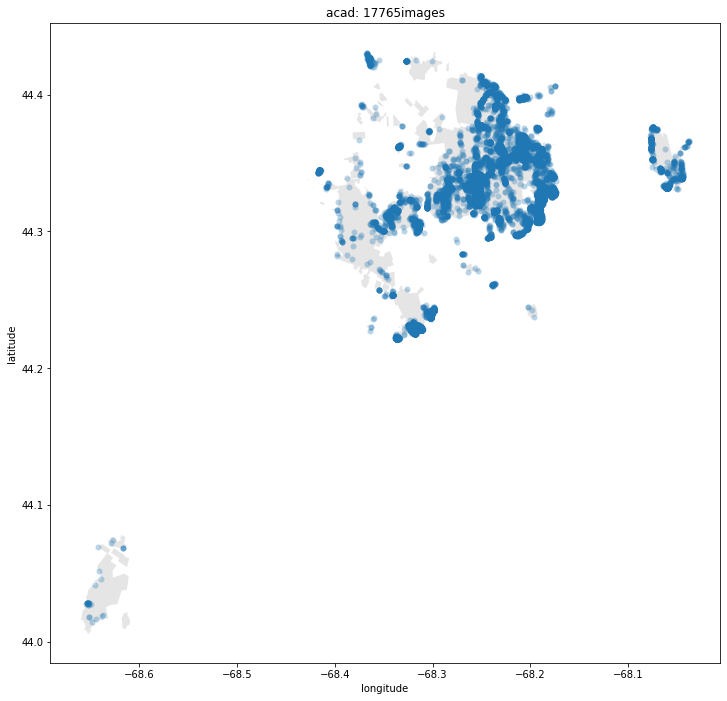

In [272]:
def show_image_loc(data):
    fig, ax = plt.subplots(figsize=(12,12))
    
    df2 = gpd.read_file('../scrapper/data/geojson/'+parkunit+'.geojson')
    df2.plot(alpha=0.2, ax=ax, color='grey')
    
    sns.scatterplot(x='longitude', y='latitude', data=data, alpha=0.3, linewidth=0)
    plt.title(parkunit + ": " + str(data.shape[0]) + "images")
    
    #plt.legend().set_visible(False)
show_image_loc(data)

In [282]:
best_score = -1
best_eps = 0
range_eps = data[~data['distance'].isnull()]['distance'].quantile([0.2,0.3,0.4,0.45,0.5,0.55,0.6])
for i in range_eps:
    if i<=0:
        continue
    if i>0.5*data['distance'].max():
        continue
    db = DBSCAN(eps=i, min_samples=5, n_jobs=-1).fit(data[['longitude', 'latitude']])
    core_sample_mask = np.zeros_like(db.labels_, dtype=bool)
    core_sample_mask[db.core_sample_indices_] = True
    labels = db.labels_
    silhouette_avg = silhouette_score(data[['longitude', 'latitude']], labels)
    print("For eps value = "+str(i), "\n\tNumber of clusters: {}".format(len(set(labels))),
         "\n\tAvg silhouette score is: {:.4f}".format(silhouette_avg))
    if best_score < silhouette_avg:
        best_score = silhouette_avg
        best_eps = i

print(best_eps, best_score)

For eps value = 9.825983978973583e-05 
	Number of clusters: 367 
	Avg silhouette score is: -0.2499
For eps value = 0.0002069874357976181 
	Number of clusters: 329 
	Avg silhouette score is: 0.0293
For eps value = 0.00041099999999971715 
	Number of clusters: 305 
	Avg silhouette score is: 0.1450
For eps value = 0.0005890097197775959 
	Number of clusters: 265 
	Avg silhouette score is: 0.2019
For eps value = 0.000894062915034218 
	Number of clusters: 209 
	Avg silhouette score is: 0.1816
For eps value = 0.0013843111887140245 
	Number of clusters: 154 
	Avg silhouette score is: 0.2656
For eps value = 0.0024472235292650165 
	Number of clusters: 91 
	Avg silhouette score is: -0.0175
0.0013843111887140245 0.26559908832069795


In [283]:
best_score = -1
best_min_samples = 0
min_samples = [3,5,6,7,8,9,10,12,14,16,18,20]
for i in min_samples:
    db = DBSCAN(eps=best_eps, min_samples=i, n_jobs=-1).fit(data[['longitude', 'latitude']])
    core_sample_mask = np.zeros_like(db.labels_, dtype=bool)
    core_sample_mask[db.core_sample_indices_] = True
    labels = db.labels_
    silhouette_avg = silhouette_score(data[['longitude', 'latitude']], labels)
    print("For min_sample value = "+str(i), "\n\tNumber of clusters: {}".format(len(set(labels))),
         "\n\tAvg silhouette score is: {:.4f}".format(silhouette_avg))
    if best_score < silhouette_avg:
        best_score = silhouette_avg
        best_min_samples = i
        
print(best_eps, best_min_samples, best_score)

For min_sample value = 3 
	Number of clusters: 228 
	Avg silhouette score is: 0.2436
For min_sample value = 5 
	Number of clusters: 154 
	Avg silhouette score is: 0.2656
For min_sample value = 6 
	Number of clusters: 146 
	Avg silhouette score is: 0.2758
For min_sample value = 7 
	Number of clusters: 135 
	Avg silhouette score is: 0.2831
For min_sample value = 8 
	Number of clusters: 127 
	Avg silhouette score is: 0.2521
For min_sample value = 9 
	Number of clusters: 127 
	Avg silhouette score is: 0.3059
For min_sample value = 10 
	Number of clusters: 119 
	Avg silhouette score is: 0.2890
For min_sample value = 12 
	Number of clusters: 107 
	Avg silhouette score is: 0.2699
For min_sample value = 14 
	Number of clusters: 99 
	Avg silhouette score is: 0.2594
For min_sample value = 16 
	Number of clusters: 90 
	Avg silhouette score is: 0.2415
For min_sample value = 18 
	Number of clusters: 83 
	Avg silhouette score is: 0.3469
For min_sample value = 20 
	Number of clusters: 79 
	Avg silhou

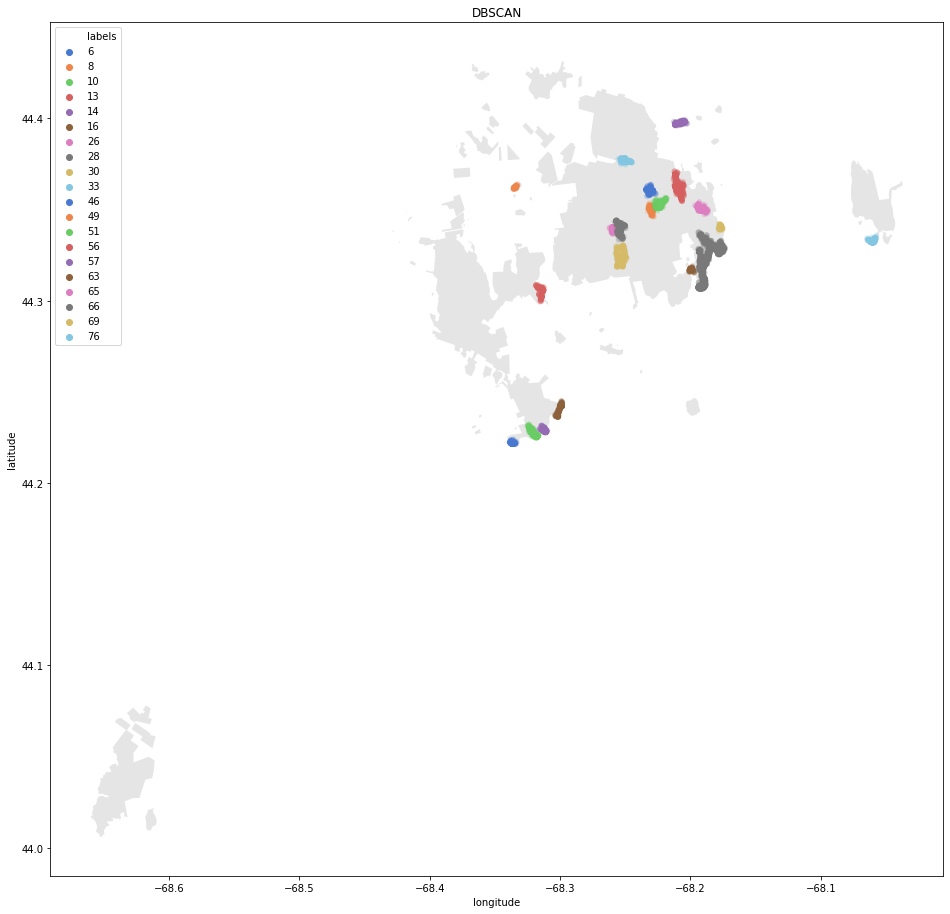

In [284]:
clustering = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1).fit(data[['longitude', 'latitude']])
labels = clustering.labels_
indices = clustering.core_sample_indices_


n_labels = 20

def dbscan(data):
    fig, ax = plt.subplots(figsize=(16,16))
    y_pred = clustering.fit_predict(data[['longitude', 'latitude']])
    data['labels'] = y_pred
    
    data = data[data['labels']!=-1]
    top_labels = set(pd.Series(data['labels']).value_counts().head(n_labels).index.to_list())
    data = data[data['labels'].map(lambda x: top_labels.issuperset([x]))]
    
    df2 = gpd.read_file('../scrapper/data/geojson/'+parkunit+'.geojson')
    df2.plot(alpha=0.2, ax=ax, color='grey')
    
    sns.scatterplot(x='longitude', y='latitude', data=data, hue='labels', alpha=0.3, linewidth=0, palette=sns.color_palette("muted", n_colors=len(top_labels)))
    plt.title("DBSCAN")
    
    #plt.legend().set_visible(False)
dbscan(data)

In [295]:
top_labels

{0, 1, 5, 7, 10, 15, 18, 22, 26, 36, 37, 40, 42, 49, 53, 56, 62, 64, 68, 72}

In [294]:
data

,latitude,longitude,latitude_diff,longitude_diff,distance,labels
7764,44.343111,-68.417251,0.274611,0.199416,0.339379,0
23096,44.342913,-68.417245,-0.000198,0.000006,0.000198,0
23095,44.342925,-68.417214,0.000012,0.000031,0.000033,0
23097,44.342994,-68.417214,0.000069,0.000000,0.000069,0
23177,44.342991,-68.417106,-0.000003,0.000108,0.000108,0
...,...,...,...,...,...,...
26156,44.363777,-68.076202,0.004357,0.000000,0.004357,72
26155,44.364605,-68.076117,0.000828,0.000085,0.000832,72
26059,44.363888,-68.076112,-0.000717,0.000005,0.000717,72
26153,44.363666,-68.076000,0.007115,0.000074,0.007115,72


In [297]:
colors = list(sns.color_palette("muted", n_colors=n_labels).as_hex())

m = my_park.show_park()
data = data[data['labels'].map(lambda x: top_labels.issuperset([x]))]

for i, row in data.iterrows():
    color = colors[int(list(top_labels).index(int(row['labels'])))]
    folium.Circle(
        radius=100,
        location=[float(row['latitude']),float(row['longitude'])],
        fill_color=color,tooltip=row['labels'],
        color = color,
        fill=True).add_to(m)
m